In [ ]:
from utils_figure_plot import DynamicUpdate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from joblib import Parallel, delayed
import random
import os
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from MLP_nutrient_antibiotic_control import CDQL as RL_model
from Naive_control import CDQL as Naive_model

In [2]:
def eval(model, plot_name='rl', num_decisions=200, num_evals=15):
        """Given trained q networks, generate trajectories
        """
        print("Evaluation")
        model.folder_name = "./Eval_Results"
        os.makedirs(model.folder_name, exist_ok=True)
        model.update_plot = DynamicUpdate(model.folder_name)

        extinct_times = []
        extinct_count = 0

        results = Parallel(n_jobs=15)(delayed(model.rollout)(num_decisions) for i in range(num_evals))
        # results = [model.rollout(num_decisions) for i in range(num_evals)]

        if plot_name == 'rl':
                b, cell_count, t, kn0, sum_rewards, *_ = list(zip(*results))
        else:
                b, cell_count, t, kn0, sum_rewards = list(zip(*results))
        for time, count in zip(t,cell_count):

            # save extinction times
            if count[-1] == 0:
                    extinct_times.append(time[-1])
                    extinct_count +=1

        model.ave_sum_rewards.append(np.array(sum_rewards).mean())
        model.std_sum_rewards.append(np.array(sum_rewards).std())
        # save results
        ave_ext_time = sum(extinct_times)/len(extinct_times) if len(extinct_times) > 0 else np.Inf
        print("extinction fraction:", extinct_count/num_evals)

        # select trajectories randomly to plot
        # rand_i = random.sample(range(num_evals), 5)
        # model.update_plot(plot_name, t, cell_count, kn0, b, rand_i)

        return extinct_count/num_evals

In [3]:
# load models to compare

training_config = {"delay_embed_len": 20, "folder_name": "./Results", "T": 12}
rl = RL_model(training_config=training_config)
folder_name = "/Users/Josiah/Documents/OSPool/feb24_nutr_drug_control2act/Fluc_nutrient"
rl.load_data(folder_name=folder_name)

naive = Naive_model()

Partially trained model found, starting from episode  350 .


In [4]:
replicates = 3
naive_fraction = []
rl_fraction = []

for i in range(replicates):
    naive_fraction.append(eval(naive, "naive"))
    rl_fraction.append(eval(rl, "rl"))

ave_naive_ext_frac = sum(naive_fraction) / len(naive_fraction)
ave_rl_ext_frac = sum(rl_fraction) / len(rl_fraction)

Evaluation


mkdir: ./Eval_Results/Eval: File exists


extinction fraction: 0.3333333333333333
Evaluation


mkdir: ./Eval_Results/Eval: File exists


extinction fraction: 1.0
Evaluation


mkdir: ./Eval_Results/Eval: File exists


extinction fraction: 0.26666666666666666
Evaluation


mkdir: ./Eval_Results/Eval: File exists


extinction fraction: 1.0
Evaluation


mkdir: ./Eval_Results/Eval: File exists


extinction fraction: 0.26666666666666666
Evaluation


mkdir: ./Eval_Results/Eval: File exists


extinction fraction: 1.0


In [5]:
naive_ext_frac_std = np.std(np.array(naive_fraction))
rl_ext_frac_std = np.std(np.array(rl_fraction))
errors = [naive_ext_frac_std, rl_ext_frac_std]

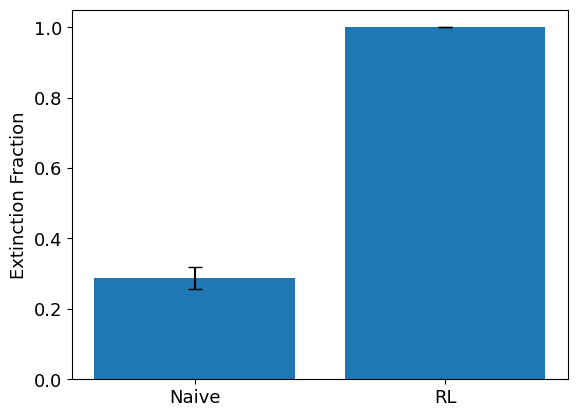

In [7]:
plt.rcParams.update({"font.size": 13})
fig = plt.figure()

control_type = ['Naive', 'RL']
extinct_fraction = [ave_naive_ext_frac, ave_rl_ext_frac]
plt.bar(control_type,extinct_fraction, yerr=errors, capsize=5)
plt.ylabel('Extinction Fraction')
plt.show()
fig.savefig('rl_vs_naive_bar_plot.pdf', dpi=300, bbox_inches='tight')

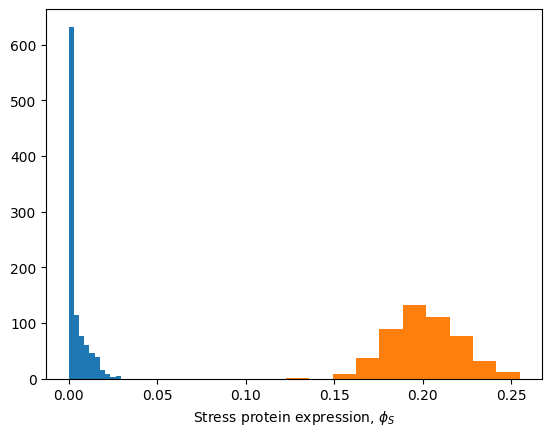

In [ ]:
# ToDo: save simulation data to recreate this type of plot

x_before = np.random.normal(0.0, scale=0.01, size=1000)
x_before = x_before.clip(0,1)
x_after = np.random.normal(0.2, scale=0.02, size=500)
plt.hist(x_before)
plt.hist(x_after)
plt.xlabel('Stress protein expression, $\phi_S$')
plt.show()